<center>
    <h1>Collaborative LSA applied on movies</h1>
    <h2>Project and Project Work in Text Mining</h2>
    <h3>Enrico Pittini enrico.pittini@studio.unibo.it</h3>
</center>



---



In this notebook, we follow the *collaborative* approach. We don't have anymore any information about the content of the movies. We have only a database of rates  in $[0..5]$ given to the movies by a community of users. By exploiting this information, still in the LSA space, we can capture the similarities and relations between movies in a very poweful way. We are also able to build a recommender system, to predict the rates given by an user to a certain movie. In this second part, three different [MovieLens](https://grouplens.org/datasets/movielens/) datasets are used: small, 100k, 1M. On each of these three datasets, the recommender system is evaluated and compared with SOTA results and with the results achieved by a paper.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

## Colab initialization for accessing the repository files on GitHub
Run this section only if you are interested in achieving the repository files on GitHub. If you have already these files, you don't need to run this section.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! mkdir "gdrive/My Drive/textmining"
! cd "gdrive/My Drive/textmining"

In [3]:
! git clone "https://github.com/EnricoPittini/LSA-on-movies"

Cloning into 'text-mining'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 327 (delta 116), reused 172 (delta 64), pack-reused 102
Receiving objects: 100% (327/327), 48.47 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Checking out files: 100% (52/52), done.


In [4]:
%cd -0
%cd "LSA-on-movies"

/content
/content/text-mining


## Initialization

In [5]:
# Settings for autoreloading
%load_ext autoreload
%autoreload 2

In [6]:
import csv
import numpy as np
import pandas as pd 

In [7]:
import warnings
warnings.filterwarnings("ignore")

## MovieLens small 
The first dataset taken into account is the MovieLens small. It is a dataset for education and development.
- Around $100$ k ratings
- Around $10$ k movies
- Around $600$ users

In [8]:
movies_file = 'datasets/collaborative/movies_small.csv'
ratings_file = 'datasets/collaborative/ratings_small.csv'

Movies dataframe

In [9]:
df_movies = pd.read_csv(movies_file)

In [10]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Ratings dataframe

In [12]:
df_ratings = pd.read_csv(ratings_file)

In [13]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [14]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Preprocessing
Some preprocessing must be performed. In particular, the users ids and the movies ids must be transformed and remapped in order to ease the futuer operations involving the rating matrix.

In [15]:
from utils.preprocessing import preprocess_movies_ratings_coll
df_movies, df_ratings = preprocess_movies_ratings_coll(df_movies, df_ratings)

In [16]:
df_movies.head()

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy


Now the movies ids are simply the indices of the movies dataframe, in the range $[0..n_{movies}]$.

The users ids are the integers in the range $[0..n_{users}]$.

In [17]:
users = df_ratings['userId'].unique()
n_users = len(users)
n_users

610

### Rating matrix
Let's now build the rating matrix. 

The rating matrix is a bidimensional matrix with shape $n_{users} \times n_{movies}$: so, the rows correspond to the users, while the columns correspond to the movies. Each cell contains the rate given from that user to that movie. 

1. **'fill_na' strategy.** A very important point is the handling of the missing values: a missing value is a cell $(user_{id},movie_{id})$ s.t. that user
has never rated that movie. These missing values must be replaced with something. The four following strategies can be specified.
    - `'zero'`. The missing values are simply replaced with $0$.
    - `'items_means'`. Each missing value is replaced with the mean of the column in which it belongs, i.e. the mean of the rates of that movie. If a movie has no rates, all its values are replaced with the global mean of all rates.
    - `'users_means'`. Each missing value is replaced with the mean of the row in which it belongs, i.e. the mean of the rates given by that user. If a user has never given a rate, all its values are replaced with the global mean of all rates.
    - `'items_users_means'`. Each missing value is replaced with the mean between the mean of the column (i.e. item mean) and the mean of the row (i.e. user mean). 

2) **'subtract_mean' strategy.** Another important point is that it is typically useful to subtract the values in the rating matrix by certain means. Basically, it is typically beneficial to do not work directly with the ratings, but working with the differences of the ratings from certain means. The four following strategies can be specified.
    - `'zero'`. Zero values are subtracted from the rating matrix values. Basically, the matrix remains as it is.
    - `'items_means'`. The items means (i.e. the means of the columns) are subtracted from the rating matrix values. Basically, each rate is subtracted with the average rate given to that movie. The purpose of this operation is to have a more balanced view of the ratings from an items point of view. Indeed, the less popular movies have lower ratings w.r.t. the popular movies, and so they will have much lower similarity scores even in cases in which they are more appropriate.
    - `'users_means'`. The users means (i.e. the means of the rows) are subtracted from the rating matrix values.  Basically, each rate is subtracted with the average rate given by that user. The purpose of this operation is to have a more balanced view of the ratings from an users point of view. Indeed, there can be generous users which are more prone to give high rates, and greedy users which instead give often low rates. In simple terms, a 3 rating given by a generous user has not the same importance of a 3 rating given by a greedy one: the former is less important and significative. Therefore, we want to normalize with respect to the users average rating.
    - `'items_users_means'`. The means between the items means and the user means are subtracted from the rating matrix values. Basically,  each rate is subtracted with the average between the average rate given to that movie and the average rate given by that user. The purpose of this operation is to normalize w.r.t. both items and users.

Both the 'fill_na' and 'subtract_mean' strategies together compose what we call a **rating strategy**. Overall, there are $16$ possible different strategies.

Let's now, for example, build the rating matrix by using `fill_na=users_means` and `subtract_mean=users_means`. 

For more details, consult the docstring of the function `build_rating_matrix`

In [18]:
from utils.preprocessing import build_rating_matrix

rating_matrix, no_rating_mask, test_dict, means_dict = build_rating_matrix(df_movies, df_ratings, n_users, 
                                                                           fill_na='users_means', 
                                                                           subtract_mean='users_means')

It is always important to remind that this rating matrix does not contain the original ratings. But it contains the ratings after the subtraction with certain means values (the ones specified by the strategy).

In [19]:
rating_matrix.shape

(610, 9742)

In [20]:
# Number of original missing values
no_rating_mask.sum()

5841784

The following is the proportion of the missing values w.r.t. all cells in the matrix. It's $0.98$, a very huge number.

In [21]:
# Sparsity factor
no_rating_mask.sum()/(rating_matrix.shape[0]*rating_matrix.shape[1])

0.9830317267467884

### LSA
Now, the Latent Semantic Analysis (LSA) is applied on the rating matrix. Basically, we apply the SVD.

Singual Values Decomposition (SVD): $$rm = u * D(s) * v^h$$

Let $d = min\{n_{users},n_{movies}\}$.
- $rm$ is the rating matrix.
- $u$ is a matrix $n_{users} \times d$. The rows correspond to the users: each row vector is the vectorial representation of the corresponding term.
- $s$ is a vector with length $d$, containing the singular values, sorted in descending order.
- $D(s)$ represents the diagonal matrix containing the singular values.
- $v^h$ is a matrix $d \times n_{movies}$. The columns correspond to the movies: each column vector is the vectorial representation of the corresponding movie.

In [22]:
u, s, vh = np.linalg.svd(rating_matrix, full_matrices=False)

In [23]:
u.shape

(610, 610)

In [24]:
s.shape

(610,)

In [25]:
vh.shape

(610, 9742)

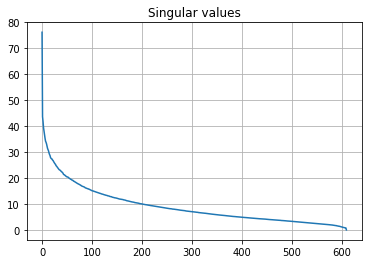

In [26]:
import matplotlib.pyplot as plt 
plt.plot(s)
plt.grid()
plt.title('Singular values');

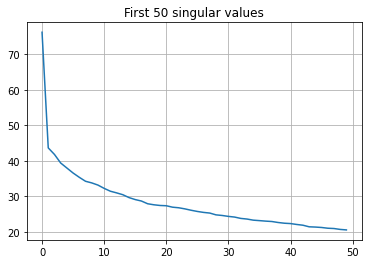

In [27]:
plt.plot(s[:50])
plt.grid()
plt.title('First 50 singular values');

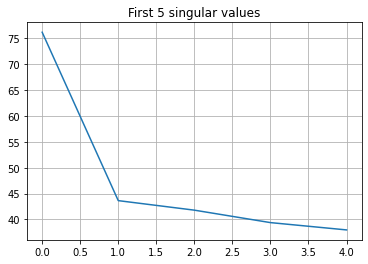

In [28]:
plt.plot(s[:5])
plt.grid()
plt.title('First 5 singular values');

In [29]:
def diff_function(x):
    return x[1:] - x[:-1]

def curvature_function(s):
    s_diff = diff_function(diff_function(s))
    return s_diff/((1+np.square(s_diff))**1.5)

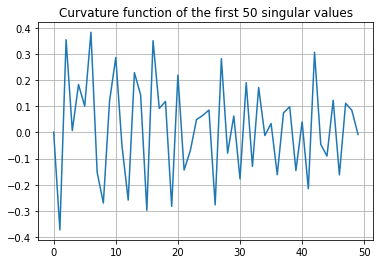

In [30]:
plt.plot(curvature_function(s)[:50])
plt.grid()
plt.title('Curvature function of the first 50 singular values');

### Similarity
Now, we can exploit the truncated SVD for capturing the similarity between movies. 

We represent each movie as a $k$-dimensional vector in the compressed LSA space. Then, by computing some metric between these vectors (in our case, cosine similarity), we hope to be able to capture the semantic similarity between movies. 

Of course, $k$ has a big impact in the quality of the results. 
- The bigger $k$, the more our sparse is our model, becoming more and more similar to the full rating matrix.
- The smaller $k$, the more compressed is our representation. We loose details and information, but hoping to gain some high-level meaning and semantic.

It is important to point out the power and beauty of the collaborative approach, by underlying the differences with the content-based one.
- In the content-based approach, we try to exploit the content (i.e. the overviews) of the movies for capturing the similarity between movies.
- In the collaborative approach, we do not use any information about the movies, but we simply use the ratings given by a community of users. By exploiting this model, in an appropriate compressed space, we can capture the semantic similarities between the movies. 

For having more information in how this is achieved, look at the function `compute_most_similar_movies_lsa_coll`. The first most similar movie is always the film itself.

In [32]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from utils.similarities import compute_most_similar_movies_lsa_coll

Let's see the most similar films to `Goodfellas`, `Star Wars: Episode IV`, `Pulp Fiction` and `Interstellar`... Quite impressive results!

In [34]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Goodfellas (1990)', df_movies=df_movies, vh=vh, s=s, k=100)
df_most_similar.head()

,movie index,title,similarity
0,914,Goodfellas (1990),1.000000
1,828,Reservoir Dogs (1992),0.728015
2,922,"Godfather: Part II, The (1974)",0.712027
3,659,"Godfather, The (1972)",0.698767
4,909,Apocalypse Now (1979),0.596851


In [35]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Star Wars: Episode IV - A New Hope (1977)', df_movies=df_movies, vh=vh, s=s, k=100)
df_most_similar.head() 

,movie index,title,similarity
0,224,Star Wars: Episode IV - A New Hope (1977),1.000000
1,898,Star Wars: Episode V - The Empire Strikes Back...,0.845900
2,911,Star Wars: Episode VI - Return of the Jedi (1983),0.779794
3,900,Raiders of the Lost Ark (Indiana Jones and the...,0.624925
4,990,Indiana Jones and the Last Crusade (1989),0.524425


In [36]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Pulp Fiction (1994)', df_movies=df_movies, vh=vh, s=s, k=50)
df_most_similar.head()

,movie index,title,similarity
0,257,Pulp Fiction (1994),1.000000
1,46,"Usual Suspects, The (1995)",0.813218
2,2226,Fight Club (1999),0.792085
3,828,Reservoir Dogs (1992),0.790005
4,43,Seven (a.k.a. Se7en) (1995),0.743790


In [37]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Interstellar (2014)', df_movies=df_movies, vh=vh, s=s, k=70)
df_most_similar.head() 

,movie index,title,similarity
0,8376,Interstellar (2014),1.000000
1,8063,Django Unchained (2012),0.645198
2,8466,Whiplash (2014),0.626852
3,8305,"Wolf of Wall Street, The (2013)",0.587546
4,8990,The Revenant (2015),0.582561


The collaborative model is able to capture many semantic things.
- Different films of the same serie. Like different films of the `Star Wars` saga.
- The genre and the kind of film. Like `Goodfellas` and `Godfather: Part II, The` are both films about mob. Or like `Goodfellas` and `Reservoir Dogs` are both 'dark' films, with a lot of violence. 
- The directors and the actors. Like `Pulp Fiction` and `Reservoir Dogs`. Or like for `Interstellar`, in which the most similar films are with Leonardo DiCaprio.

Others examples will be also shown later, with the others datasets.



By using different rating strategies, the similarities results are different. 

In particular, we have noticed that using a 'subtract_mean' strategy involving the items means, it can end up in being more fair with non-popular films. Indeed, if we do not use the items means, most of the times the most similar films are very popular films, with a lot of ratings. Instead, using the items means, non-popular movies appear much more often among the most similar movies. However, this is not always beneficial. Like in the following examples about `Pulp Fiction` and `Goodfellas`.

In [38]:
rating_matrix, no_rating_mask, test_dict, means_dict = build_rating_matrix(df_movies, df_ratings, n_users, 
                                                                           fill_na='items_means', 
                                                                           subtract_mean='items_means')
u, s, vh = np.linalg.svd(rating_matrix, full_matrices=False)

In [39]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Pulp Fiction (1994)', df_movies=df_movies, vh=vh, s=s, k=100)
df_most_similar.head()

,movie index,title,similarity
0,257,Pulp Fiction (1994),1.000000
1,600,"Stupids, The (1996)",0.397032
2,2226,Fight Club (1999),0.392891
3,635,Alaska (1996),0.383143
4,46,"Usual Suspects, The (1995)",0.376493


In [40]:
df_most_similar = compute_most_similar_movies_lsa_coll(movie_title='Goodfellas (1990)', df_movies=df_movies, vh=vh, s=s, k=100)
df_most_similar.head()

,movie index,title,similarity
0,914,Goodfellas (1990),1.000000
1,828,Reservoir Dogs (1992),0.459824
2,5061,Zelig (1983),0.448357
3,997,"Killing Fields, The (1984)",0.443723
4,4671,Slacker (1991),0.437832


We have instead found that using users means in the 'subtract_mean' strategy is typically beneficial. Probably, normalizing the ratings by the users 'generosities' is effective in capturing the similarity between movies.

### Processing genres
Let's process the genres column, in order to contain the set of genres of each movie.

In [41]:
df_movies['genres'] = df_movies['genres'].map(lambda s: set(s.split('|')))

In [42]:
genres = set([])
df_movies['genres'].map(lambda genres_set: genres.update(genres_set))
print(genres)

{'IMAX', 'Thriller', 'Musical', 'Mystery', 'Horror', '(no genres listed)', 'Sci-Fi', 'Comedy', 'Drama', 'Children', 'Western', 'Romance', 'Animation', 'War', 'Film-Noir', 'Crime', 'Adventure', 'Action', 'Documentary', 'Fantasy'}


### Visualization
Let's try to visualize the movies vectors among two of the first LSA dimensions. For the visualization, we have typically found more beneficial to use 'zero' or 'items' strategies.

In [43]:
rating_matrix, no_rating_mask, test_dict, means_dict = build_rating_matrix(df_movies, df_ratings, n_users, 
                                                                           fill_na='zero', 
                                                                           subtract_mean='zero')
u, s, vh = np.linalg.svd(rating_matrix, full_matrices=False)

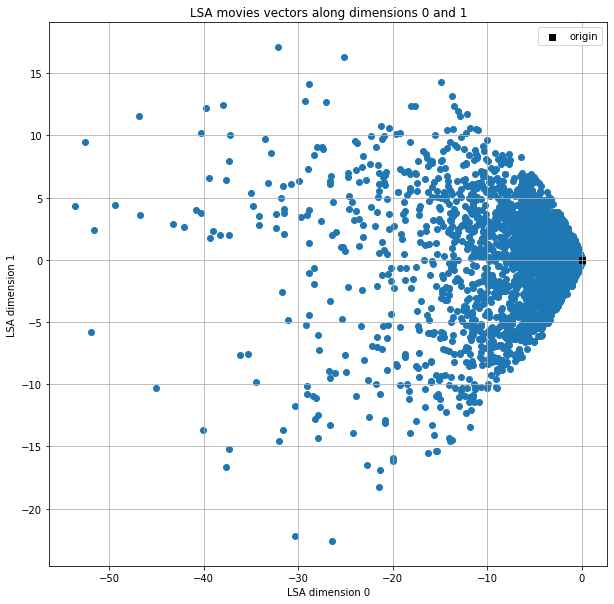

In [44]:
from utils.visualization import plot_movies

plot_movies(vh=vh, s=s)

Distribution similar to the ones seen in the content-based approach.

Let's plot some known movies. Also here, some kind of polarization up-left / bottom-left can be noticed. We have made this plot along dimensions $0$ and $4$ because thse dimensions enlight more this polarization of dark-bright movies. 

In [45]:
movies_of_interest = ['Titanic (1997)', 'While You Were Sleeping (1995)', 'Grease (1978)', 'Pretty Woman (1990)', 
                      'Goodfellas (1990)', 'Casino (1995)', 'Psycho (1960)', 'Shining, The (1980)']
movies_subset = []
for movie_of_interest in movies_of_interest:
    movies_subset += list(df_movies[df_movies['title'].map(lambda t: movie_of_interest==str(t))].index)

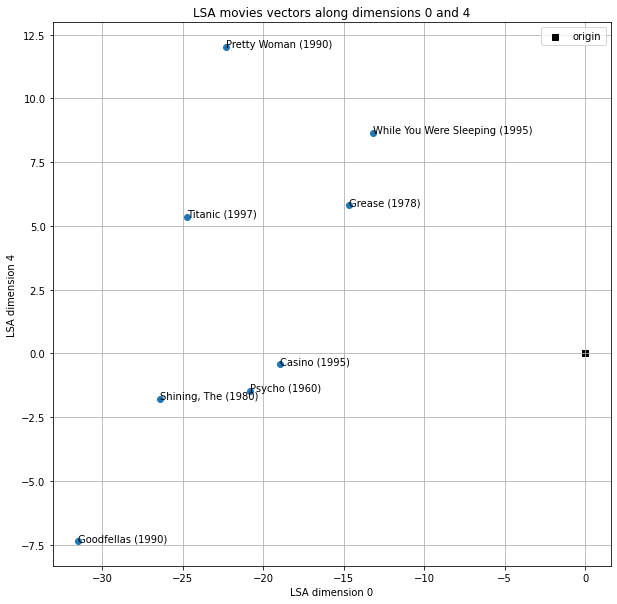

In [46]:
plot_movies(vh, s, dimensions=(0,4), labels=df_movies['title'].to_numpy(), subset=movies_subset)

Let's briefly analyze also the genres.

As expected, the `Comedy` genre is quite broad.

In [47]:
from utils.visualization import plot_genres_analysis_coll

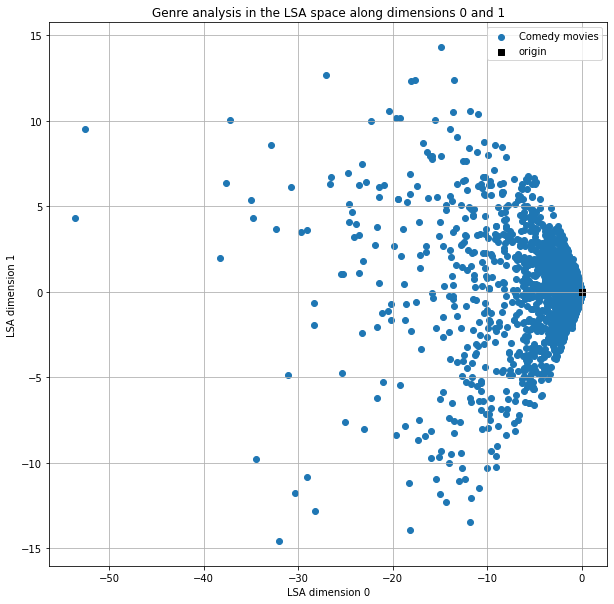

In [48]:
plot_genres_analysis_coll(vh=vh, s=s, df_movies=df_movies, genres=['Comedy'])

Polarization `Romance`/`Sci-Fi`. Still dimensions $0$ and $4$.

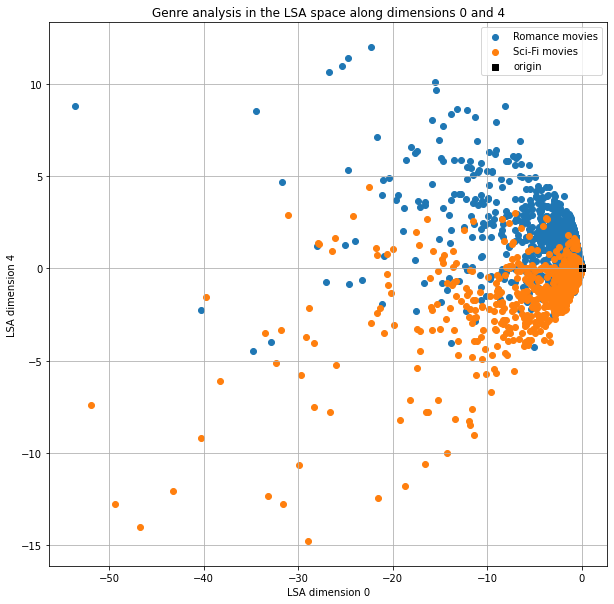

In [49]:
plot_genres_analysis_coll(vh=vh, s=s, df_movies=df_movies, genres=['Romance', 'Sci-Fi'], dimensions=(0,4))

Polarization `Romance` / `Horror`.

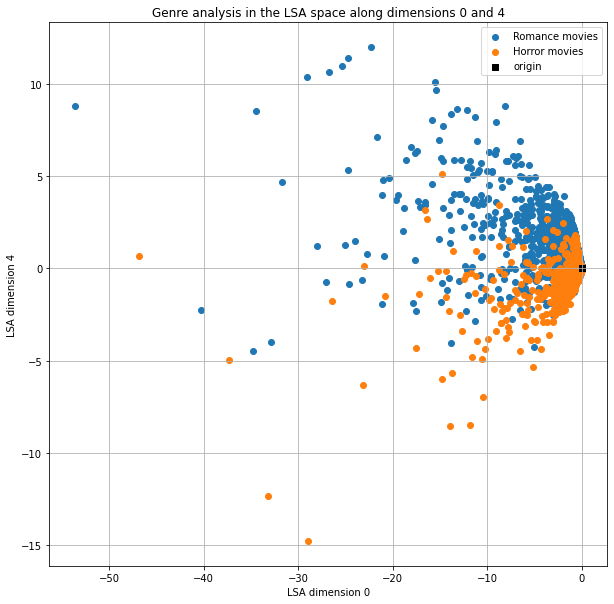

In [50]:
plot_genres_analysis_coll(vh=vh, s=s, df_movies=df_movies, genres=['Romance', 'Horror'], dimensions=(0,4))

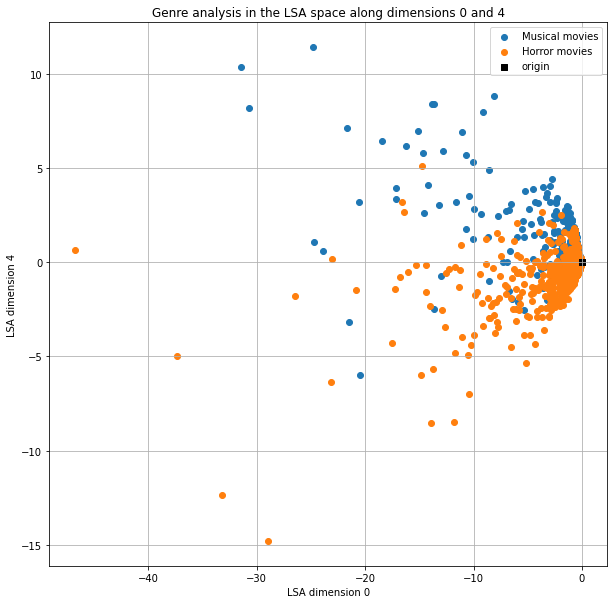

In [51]:
plot_genres_analysis_coll(vh=vh, s=s, df_movies=df_movies, genres=['Musical', 'Horror'], dimensions=(0,4))

### Rates prediction
In this section, we use the strategy 'items_users'.

In [52]:
rating_matrix, no_rating_mask, test_dict, means_dict = build_rating_matrix(df_movies, df_ratings, n_users, 
                                                                           fill_na='items_users_means', 
                                                                           subtract_mean='items_users_means')
u, s, vh = np.linalg.svd(rating_matrix, full_matrices=False)

In [53]:
# In this section, we need also information about the used means and about the nan mask
test_mask, test_target = test_dict['test_mask'], test_dict['test_target']
items_means, users_means, items_users_means = means_dict['items_means'], means_dict['users_means'], means_dict['items_users_means']

nan_mask = np.logical_or(no_rating_mask, test_mask)

With our model, we can also predict which is the rate given by a certain user to a certain movie. 

If $uk$ is the user vector in the $k$-dimensional LSA space and $mk$ is the movie vector in the $k$-dimensional LSA space, their dot product gives us the predicted rate. Of course, the two vectors must be first scaled according to the singular values. Basically, yhe formula is the following. $$(\sqrt{sk} * uk) * (\sqrt{sk} * mk)$$, where $sk$ are the first $k$-th singual values.

This is very similar to computing the similarity between an user and a movie. We can also notice that this value is exactly equal to the value in the cell related to that user and movie of the reconstructed rating matrix, obtained using the $k$-rank SVD approximation. Estimation/approximation of the original rating matrix (i.e. of the true ratings), by means of the compressed $k$-dimensional LSA space.

Actually, an important precisation must be done. What we achieve by proceding in this way are not the actual ratings in the range $[0..5]$, but are the ratings after having subtracted certain means (specified by the strategy). Basically, since we are trying to reconstruct the rating matrix and since the rating matrix contains the ratings after having subtracted the means, we are predicting these normalized values, and not the rates in $[0..5]$. For obtaining the rates we have to simply sum the used means.

In [54]:
from utils.rating import predict_ratings, evaluate, rebuild_rating_matrix

Reconstruction/prediction of the rating matrix, with $k=100$. These are the normalized values.

In [55]:
rating_matrix_pred = predict_ratings(u, s, vh, k=100)
print(rating_matrix_pred)

[[-4.28436974e-01 -2.43417660e-01  2.63600393e-01 ...  2.86279932e-04
   2.86279932e-04 -2.70794988e-03]
 [-7.54749421e-03 -1.64402034e-02 -1.55341786e-02 ...  2.99113917e-05
   2.99113917e-05 -1.39921653e-03]
 [ 1.40372133e-01  1.72804624e-01  1.81854978e-02 ... -9.44674328e-04
  -9.44674328e-04 -8.95800493e-04]
 ...
 [-1.03531254e+00 -1.37664407e+00 -1.25818298e+00 ...  2.59039734e-04
   2.59039734e-04 -5.51903823e-03]
 [-1.03310641e-01 -4.34966171e-02 -5.71694544e-02 ... -6.46901303e-06
  -6.46901303e-06 -9.34053083e-05]
 [ 1.29222218e+00  5.96506955e-02 -4.33002306e-02 ... -5.76867522e-04
  -5.76867522e-04  9.91651270e-03]]


True rating matrix, normalized values.

In [56]:
print(rating_matrix)

[[-0.14365477  0.          0.18700265 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-1.02755296 -1.28299694 -1.19689554 ...  0.          0.
   0.        ]
 [-0.59560025  0.          0.         ...  0.          0.
   0.        ]
 [ 1.19525685  0.          0.         ...  0.          0.
   0.        ]]


Let's now see the predicted rates in $[1..5]$ and the actual ones. We just sum the used means (items-users in our case). We also mask out the original missing values.

In [57]:
# Predicted rates
rating_matrix_pred_rebuilt = rebuild_rating_matrix(rating_matrix_pred, means=items_users_means, nan_mask=nan_mask)
print(rating_matrix_pred_rebuilt)

[[3.7152178         nan 4.07659774 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [2.49224042 1.90635287 1.93871255 ...        nan        nan        nan]
 [3.49228961        nan        nan ...        nan        nan        nan]
 [5.09696533        nan        nan ...        nan        nan        nan]]


In [58]:
# True rates
rating_matrix_rebuilt = rebuild_rating_matrix(rating_matrix, means=items_users_means, nan_mask=nan_mask)
print(rating_matrix_rebuilt)

[[4.  nan 4.  ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [2.5 2.  2.  ... nan nan nan]
 [3.  nan nan ... nan nan nan]
 [5.  nan nan ... nan nan nan]]


### Evaluation

We can evaluate the goodness of our predictions, by using *Root Mean Squared Error (RMSE)* or *Absolute Mean Error (MAE)*. Of course, we mask out the original missing values. 

In [59]:
# Dumb model: always predict 0
rmse = evaluate(rating_matrix, np.zeros(shape=rating_matrix.shape), mask_no_evaluate=nan_mask)
rmse

0.8472345365804169

In [60]:
# k=5
rating_matrix_pred = predict_ratings(u, s, vh, k=5)
rmse = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask, metric='rmse')
rmse

0.7861301019161094

In [61]:
# k=50
rating_matrix_pred = predict_ratings(u, s, vh, k=50)
rmse = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask, metric='rmse')
rmse

0.5777508946767753

In [62]:
# k=100
rating_matrix_pred = predict_ratings(u, s, vh, k=100)
rmse = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask, metric='rmse')
rmse

0.4435976834253355

In [63]:
# k=300
rating_matrix_pred = predict_ratings(u, s, vh, k=300)
rmse = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask, metric='rmse')
rmse

0.17166414765226218

In [64]:
# k=300
rating_matrix_pred = predict_ratings(u, s, vh, k=500)
rmse = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask, metric='rmse')
rmse

0.04357868916928781

Of course, the bigger $k$, the better is our model in making the predictions. The error becomes smaller and smaller. 

This because we are using more and more dimensions, going toward using all the original dimensions. We are simply reconstructing back the matrix using the truncated SVD: if $k$ is equal to the original rank, we get back exactly the true rating matrix. So the error is $0$!

In [65]:
rebuild_rating_matrix(rating_matrix, items_users_means, nan_mask)

array([[4. , nan, 4. , ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [2.5, 2. , 2. , ..., nan, nan, nan],
       [3. , nan, nan, ..., nan, nan, nan],
       [5. , nan, nan, ..., nan, nan, nan]])

In [71]:
# @title Reconstructed rating matrix with different k: tuning k { run: "auto" }

k = 415 #@param {type:"slider", min:0, max:500, step:1}

k = int(k)
print(rebuild_rating_matrix(predict_ratings(u, s, vh, k=k), items_users_means, nan_mask), end='')

[[4.00752581        nan 4.00217896 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [2.49715054 2.00183543 2.00075256 ...        nan        nan        nan]
 [3.1994648         nan        nan ...        nan        nan        nan]
 [5.00288162        nan        nan ...        nan        nan        nan]]

However, this is not a fair and interesting evaluation of our model. We are like cheating: we knew the true rates, we compressed them, and then we reconstruct them back. We would like to evaluate our model in predicting rates which we don't know at all!

### Train - Test evaluation
We would like to evaluate our model in a test set, like in classic ML. Several approaches can be followed for implementing that in our context. We use the following one.

A random subset of the ratings is taken and considered as test set: the proportion of this test set is arbitrary, and we fix it has $0.2$. These test set rates are 'masked out', in the sense that they are treated as missing values (handled in the same way of all the others missing values, using the 'fill_na' strategy). Of course, the true test set rates are kept and returned to the user, because they will be necessary for the evaluation.

This is implemented in the `build_rating_matrix` function.

In [72]:
rating_matrix, no_rating_mask, test_dict, means_dict = build_rating_matrix(df_movies, df_ratings, n_users, 
                                                                           fill_na='items_users_means', 
                                                                           subtract_mean='items_users_means', test_prop=0.2)

In [73]:
# Let's extract the needed information

# test_mask: boolean mask telling me where are the test set cells in the matrix
# test_target: actual test set rates
test_mask, test_target = test_dict['test_mask'], test_dict['test_target']

# Information about the means
items_means, users_means, items_users_means = means_dict['items_means'], means_dict['users_means'], means_dict['items_users_means']

# Boolean mask telling me where are missing values in the matrix: either original missing rates or test set cells
nan_mask = np.logical_or(no_rating_mask, test_mask)

In [74]:
# Sparsity factors
print(f'Sparsity factor of the original missing rates: {no_rating_mask.sum()/(rating_matrix.shape[0]*rating_matrix.shape[1]):.4f}')
print(f'Sparsity factor after masking out the test set cells: {nan_mask.sum()/(rating_matrix.shape[0]*rating_matrix.shape[1]):.4f}', )

Sparsity factor of the original missing rates: 0.9830
Sparsity factor after masking out the test set cells: 0.9864


In [75]:
u, s, vh = np.linalg.svd(rating_matrix, full_matrices=False)

In [76]:
rating_matrix_pred = predict_ratings(u, s, vh, k=50)

# Error on the train set cells, i.e. no missing rate and no test set cell
train_err = evaluate(rating_matrix, rating_matrix_pred, mask_no_evaluate=nan_mask)
print(f'Train error: {train_err:.2f}')

# Error on the test set cells
test_pred = (rating_matrix_pred+items_users_means)[test_mask]
test_err = evaluate(test_target, test_pred)
print(f'Test error: {test_err:.2f}')

Train error: 0.58
Test error: 0.89


The test error is higher, as expected

### Train - Test evaluation: different k
This evaluation can be performed at different $k$, and visualizing the plots. The best $k$ is the one with lowest test error.

We use this function `compute_train_test_errors`, to which we specify the particular rating strategy we want to use. Look at the docstring for more details.

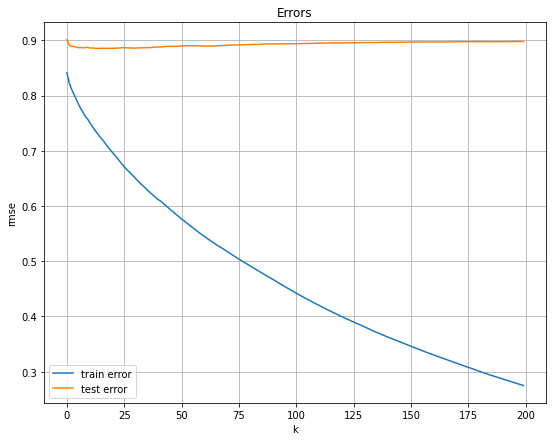

min err: 0.8851680769313368; best k: 14


In [77]:
from utils.rating import compute_train_test_errors

train_err_list, test_err_list = compute_train_test_errors(df_movies, df_ratings, n_users=n_users, fill_na='items_users_means',
                                                          subtract_mean='items_users_means')

We can see that this is compliant with the classic plot of train-test errors in ML.

Let's see only the test errors

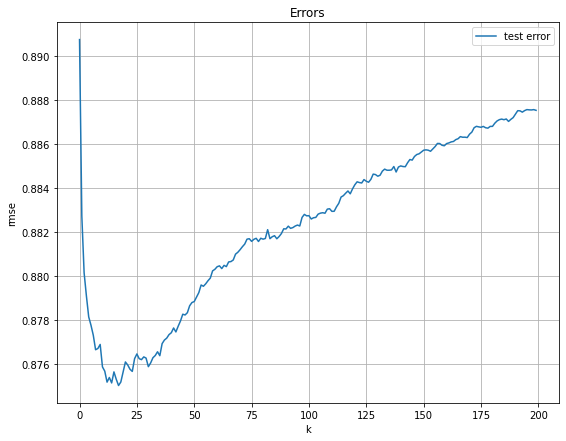

min err: 0.8750089237901935; best k: 17


In [78]:
train_err_list, test_err_list = compute_train_test_errors(df_movies, df_ratings, n_users=n_users, fill_na='items_users_means',
                                                          subtract_mean='items_users_means', plot_train=False)

We can also specify to perform a cross-validation approach. `cv_splits` different training-test couples are generated and, for each $k$, their training-test scores are aggregated, in order to compute the single couple train_err-test_err for that $k$. Basically, not a single splitting training-test is considered, but `cv_splits` different ones.

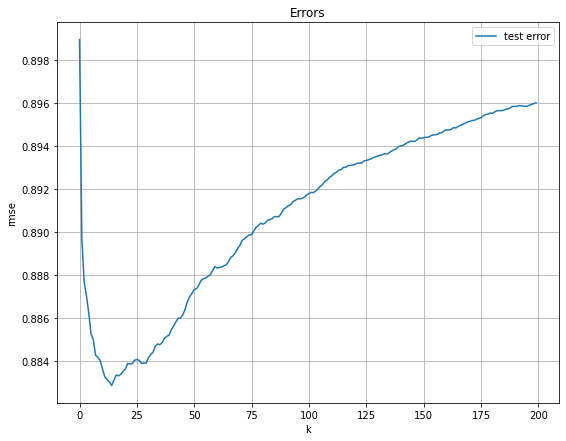

min err: 0.8828523399637399; best k: 14


In [79]:
train_err_list, test_err_list = compute_train_test_errors(df_movies, df_ratings, n_users=n_users, fill_na='items_users_means',
                                                          subtract_mean='items_users_means', cv_splits=5, plot_train=False)

The plot is less noisy.

### Comparison of different rating strategies
We can apply this same thing on different ratings strategies, for comparign them. A rating strategy name is encoded as '{fill_na_strategy}/{subtract_mean_strategy}'

In [ ]:
from utils.rating import compare_rating_strategies
help(compare_rating_strategies)

Help on function compare_rating_strategies in module utils.rating:

compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies, k_range=(0, 200), test_prop=0.2, random_seed=44, metric='rmse', cv_splits=1)
    Compare different rating strategies.
    
    A rating strategy is the combination of a `fill_na` (i.e. a strategy for silling the missing values) and a `subtract_mean`
    (i.e. a strategy for subtracting the values in the rating matrix).
    
    The different strategies are compared by measuring the test errors among all the different 'k' values specified with `k_range`.
    For each strategy and for each 'k', an error score is computed.
    The test error plot of each rating strategy is made, for having a visualization of the comparison.
    In the end, the best strategy with the best score and the best 'k' are printed in the console.
    
    This function is implemented using the `compute_train_test_errors` function. 
    As exaplained in the docstring of th

First of all, the strategies with 'zero' are much worse. We evaluate them separately.

Best strategy: zero/users
Best k: 0
Best error: 0.9405649272828601


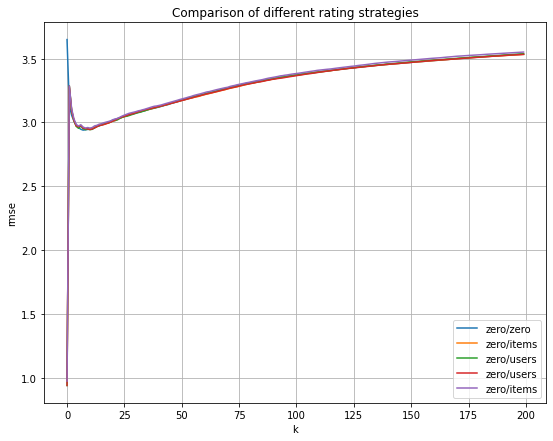

In [ ]:
rating_strategies = ['zero/zero', 'zero/items', 'zero/users', 'zero/users', 'zero/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies)

Let's move to more interesting comparisons.

Best strategy: items_users/items_users
Best k: 19
Best error: 0.8925142809755361


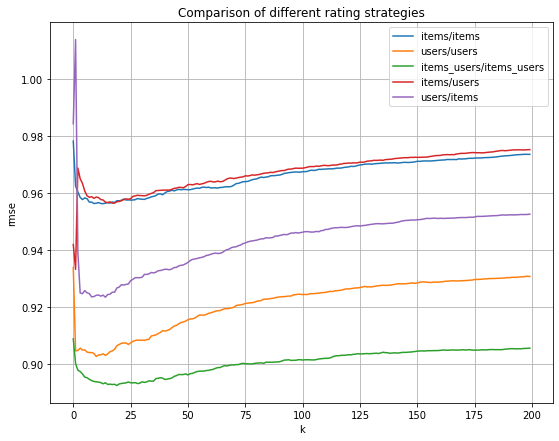

In [ ]:
rating_strategies = ['items/items', 'users/users', 'items_users/items_users', 'items/users', 'users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies)

The best one is 'items_users_mean/items_users_mean'. Let's compare also with the remaining options.

Best strategy: items_users/users
Best k: 15
Best error: 0.8853423490702353


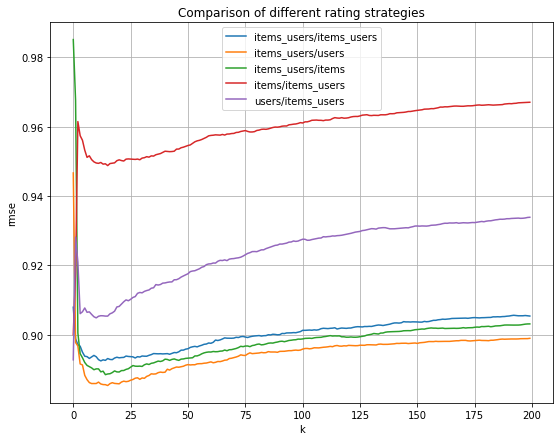

In [ ]:
rating_strategies = ['items_users/items_users', 'items_users/users', 'items_users/items', 'items/items_users', 'users/items_users']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies)

The best one is 'items_users_means/users_means'.

## MovieLens 100k 
Let's move to a more ineteresting dataset, which is used in practice for evaluation purposes.
- Around $100$ k ratings
- Around $1700$ movies
- Around $1000$ users

In [ ]:
movies_file = 'datasets/collaborative/movies_100k.item'
ratings_file = 'datasets/collaborative/ratings_100k.data'

In [ ]:
col_n = ['movie id' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              "Children's" , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western']


df_movies = pd.read_csv(movies_file, 
                       sep = '|',encoding = 'latin-1',names=col_n )

In [ ]:
df_movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie id            1682 non-null   int64  
 1   movie title         1682 non-null   object 
 2   release date        1681 non-null   object 
 3   video release date  0 non-null      float64
 4   IMDb URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

We have the problem that the genres are not encoded as a single column, but they are one-hot encoded. Let's fix this.

In [ ]:
from utils.preprocessing import preprocess_dfMovies_100k_coll

df_movies = preprocess_dfMovies_100k_coll(df_movies)
df_movies.head()

,movie id,movie title,genres
0,1,Toy Story (1995),"{Animation, Children's, Comedy}"
1,2,GoldenEye (1995),"{Thriller, Adventure, Action}"
2,3,Four Rooms (1995),{Thriller}
3,4,Get Shorty (1995),"{Drama, Comedy, Action}"
4,5,Copycat (1995),"{Thriller, Drama, Crime}"


Let's also rename the columns, in order to be compliant with the interface of before.

In [ ]:
df_movies = df_movies.rename(columns={'movie id':'movieId', 'movie title':'title'})

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  1682 non-null   int64 
 1   title    1682 non-null   object
 2   genres   1682 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.5+ KB


In [ ]:
df_ratings = pd.read_csv(ratings_file,
                      sep = '\t',names= ['UseID', 'ItemID', 'rating', 'Timestamp' ])

In [ ]:
df_ratings.head()

,UseID,ItemID,rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   UseID      100000 non-null  int64
 1   ItemID     100000 non-null  int64
 2   rating     100000 non-null  int64
 3   Timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Rename also its columns.

In [ ]:
df_ratings = df_ratings.rename(columns={'ItemID':'movieId', 'UseID':'userId'})

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100000 non-null  int64
 1   movieId    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   Timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


### Preprocessing
Same preprocessing of before, for the users ids and movies ids.

In [ ]:
from utils.preprocessing import preprocess_movies_ratings_coll

In [ ]:
df_movies, df_ratings = preprocess_movies_ratings_coll(df_movies, df_ratings)

In [ ]:
users = df_ratings['userId'].unique()
n_users = len(users)
n_users

943

In [ ]:
print(f'Sparsity factor: {1-df_ratings.shape[0]/(n_users*df_movies.shape[0])}')

Sparsity factor: 0.9369533063577546


This dataset is more dense.

### Evaluation
The evaluation on this dataset is more interesting. For two reasons.
1. [Here](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k) (paperswithcode) we can find the SOTA results on this dataset. (Even if the evaluation strategy is not exactly the same, but at least we can get a sense of the numbers). 
2. [In this paper](https://www.researchgate.net/publication/253996195_Evaluation_of_standard_SVD-based_techniques_for_Collaborative_Filtering) a very similar comparison has been carried out on this dataset. The paper makes the comparisons between three methods: the first two are basically mine 'items_means/users_means' and 'users_means/items_means' strategies. While the third one is a different strategy. However, we explote more different combinations. And we are able to reach a lowest score, using the strategy 'items_users_means/items_users_means'.

**RMSE** (for comparison with paperswithcode)

Best strategy: items_users/items_users
Best k: 10
Best error: 0.948645419762318


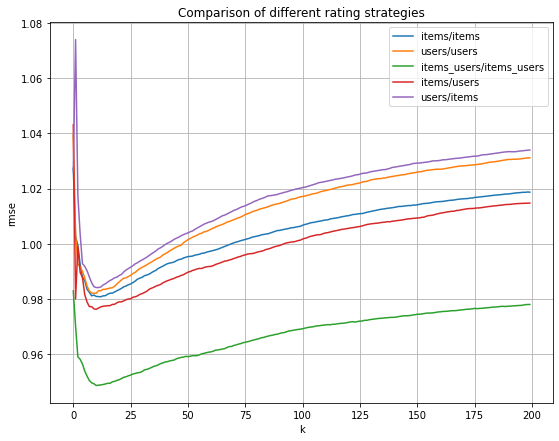

In [ ]:
rating_strategies = ['items/items', 'users/users', 'items_users/items_users', 'items/users', 'users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, cv_splits=5)

The strategy 'items_users_means/items_users_means' is much better than the others. It reaches scores which were the SOTA in 2015/2016.

Best strategy: items_users/items_users
Best k: 11
Best error: 0.9466428081233659


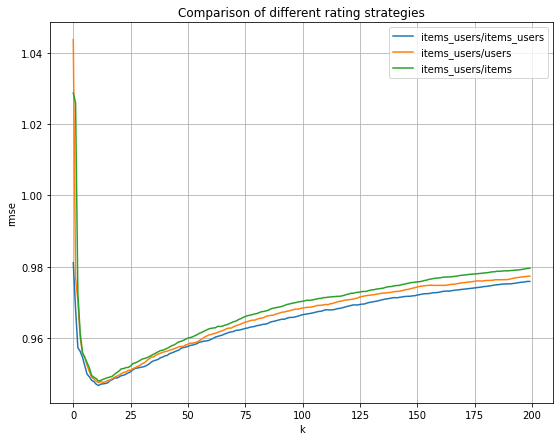

In [ ]:
rating_strategies = ['items_users/items_users', 'items_users/users', 'items_users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, cv_splits=5)

These strategies are instead pretty much the same.

**MAE** (for comparison with the paper)

Best strategy: items_users/items_users
Best k: 18
Best error: 0.757858228001773


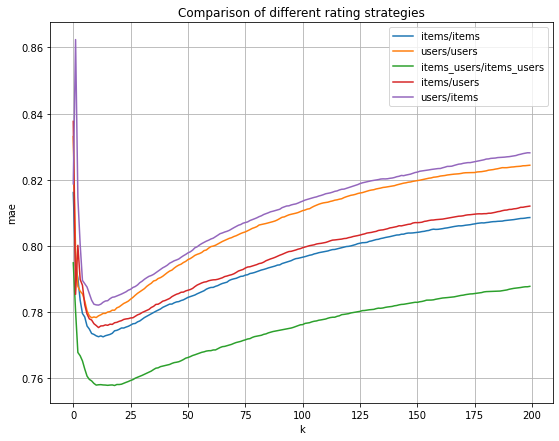

In [ ]:
rating_strategies = ['items/items', 'users/users', 'items_users/items_users', 'items/users', 'users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, metric='mae', cv_splits=5)

The strategies 'items/users' and 'users/items' reach pretty similar results to the ones of the paper: the best results are around $0.78$. The strategy 'items_users/items_users' reaches quite better performances: around $0.76$.

Best strategy: items_users/users
Best k: 11
Best error: 0.7557501144821936


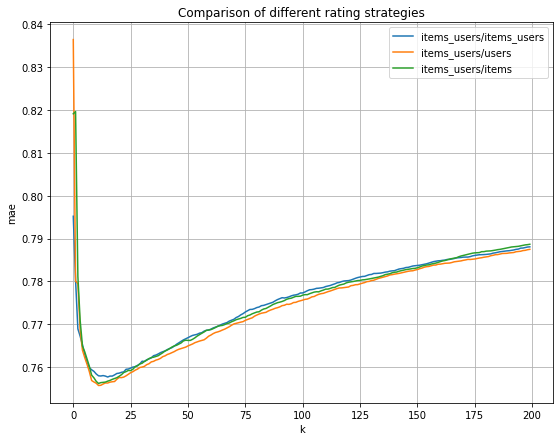

In [ ]:
rating_strategies = ['items_users/items_users', 'items_users/users', 'items_users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, metric='mae', cv_splits=5)

As before, pretty much same results.

## MovieLens 1M
Let's move to the final dataset, which is a biggest one.
- Around $1$ M ratings
- Around $4000$ movies
- Around $6000$ users

In [ ]:
movies_file = 'datasets/collaborative/movies_1M.dat'
ratings_file = 'datasets/collaborative/ratings_1M.dat'

In [ ]:
mnames = ['movie_id', 'title', 'genres']
df_movies = pd.read_table(movies_file, sep='::', header=None, names=mnames, engine='python', encoding='latin-1')

In [ ]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [ ]:
df_movies = df_movies.rename(columns={'movie_id':'movieId'})

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [ ]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
df_ratings = pd.read_table(ratings_file, sep='::', header=None, names=rnames, engine='python')


In [ ]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
df_ratings = df_ratings.rename(columns={'movie_id':'movieId', 'user_id':'userId'})

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


### Preprocessing

In [ ]:
df_movies, df_ratings = preprocess_movies_ratings_coll(df_movies, df_ratings)

In [ ]:
users = df_ratings['userId'].unique()
n_users = len(users)
n_users

6040

In [ ]:
print(f'Sparsity factor: {1-df_ratings.shape[0]/(n_users*df_movies.shape[0])}')

Sparsity factor: 0.9573532020200125


A little bit more sparse than 100k

### Evaluation
[Here](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m) (paperswithcode) we can find the SOTA results on this dataset. (Even if the evaluation strategy is not exactly the same, but at least we can get a sense of the numbers). 

We use RMSE (for comparison with paperswithcode)

Best strategy: items_users/items_users
Best k: 25
Best error: 0.9081147417808068


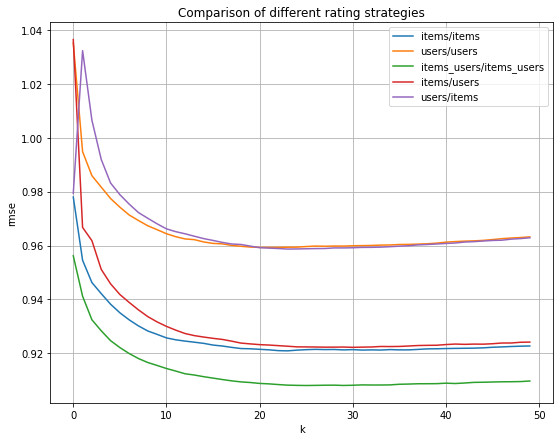

In [ ]:
rating_strategies = ['items/items', 'users/users', 'items_users/items_users', 'items/users', 'users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, k_range=(0,50))

The strategy 'items_users_means/items_users_means' is better than the others also in this case. It reaches scores which were the SOTA in 2015/2016.

Best strategy: items_users/items_users
Best k: 32
Best error: 0.9089351645776419


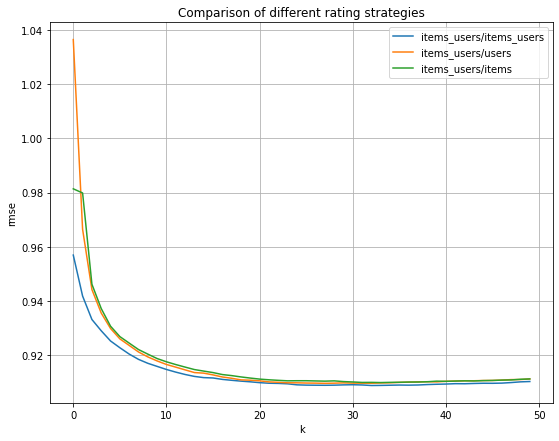

In [ ]:
rating_strategies = ['items_users/items_users', 'items_users/users', 'items_users/items']
compare_rating_strategies(df_movies, df_ratings, n_users, rating_strategies=rating_strategies, k_range=(0,50))

These strategies are instead pretty much the same.